# TP1 - Neural Networks from scratch

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework).

Following code allows you to mount your drive in the Colab Virtual Machine in order to get access to the data (skipped if run locally)

In [25]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'DEEPL'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

## Part 0. A simple Multi-Layer Perceptron (MLP) implementation

As always some useful imports:

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import scipy.ndimage as ndimage
import scipy.optimize as optimize

import os

try:
    # tqdm is a very useful library to monitor the progression of your loops
    # (not necessary but handy)
    from tqdm.notebook import tqdm
except ImportError:
    pass

We will consider a Neural Network as a modular architecture, all layer and loss being a `Module`. We define the `Linear`, `ReLU` layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the meaned square error function, `MSE`.

**Q1.a.** Read carefully the code below, and summarize in a few sentences what is the structure and the purpose of each class.

**Your answer**

The class Module defines the most simple instance, with all the other classes inheriting from it. It defines two atributes, gradInput and output, and two methods, forward and backward, which are not implemented in this class. Therefore, this class serves as a skeleton for the rest.

The class MSE defines the loss function which will be used in the training. It creates a new attribute named num_classes, which for our dataset has the value 10. As for the methods, it defines make_target, which creates a matrix of size (batch_size, num_classes) with the value 1 in the position of the label and 0 everywhere else, for each entry of the batch. The forward method calculates the MSE loss between the batch and the labels. The backward method calculates the derivative of the loss with respect to x.

The class Linear defines a linear layer of the neural network. As for the attributes, it takes the input/output sizes and it also initializes the weights and bias for training. The weights are initialized in a smart way in order to not kill the gradient. As for the methods, the forward method is simply the affine function x*weights+bias. The backward method is the recursive step which calculates the derivative of the loss with respect to the weights, in order to update them. It also passes the gradient value to the next layer. Finally, the gradientStep method performs one step of the optimization of the weights and bias.

The class ReLu defines the non-linearity used in the neural network. The forward method calculates ReLu = max(x,0). The backward method calculates the derivative of ReLu with respect to x.

The class SimpleMLP assambles the layers which were previously defined into a MLP. Its attributes are a fully connected layer with size (in_dimension X 64), a ReLu and another fully connected layer with size (64 X num_classes). As for the methods, the forward pass performs a composition between the functions defined by the layers and applies it to the input x. The backward pass calculates the derivate of the loss with respect to the weights. Finally, the gradientStep method performs one iteration of the optimization of the MLP parameters.

In [27]:
class Module(object):
    def __init__(self):
        self.gradInput = None
        self.output = None

    def forward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError

    def backward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError


class MSE(Module):
    """
    This implementation of the mean squared loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (batch_size)
    """
    def __init__(self, num_classes=10):
        super(MSE, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1

        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        self.output = np.sum((target-x)**2, axis=1)
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = -2*(target - x) / x.shape[0]
        return self.gradInput


class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        std = math.sqrt(2/in_features) # He init because we have ReLU.
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr):
        self.weight = self.weight - lr*self.gradWeight
        self.bias = self.bias - lr*self.gradBias


class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()

    def forward(self, x):
        self.output = x.clip(0)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = (x>0) * gradOutput
        return self.gradInput


class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

## Part Ia. Training a neural network

To train a network, we will need data. Download the Mini-MNIST data (~4Mo). It consists of 28×28 images (loaded as vectors of size 784) and the associated label for training and test sets.

n_train=9000, n_val=1000, n_test=2000
5


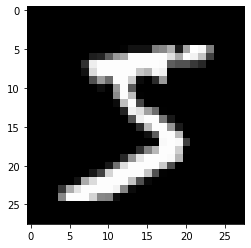

In [28]:
data = np.load("mini_mnist.npz")

train_data = data["train_data"]
train_labels = data["train_labels"]
test_data = data["test_data"]
test_labels = data["test_labels"]

N_val = int(0.1 * len(train_data))
val_data = train_data[-N_val:]
val_labels = train_labels[-N_val:]

N_train = len(train_data) - N_val
train_data = train_data[:N_train]
train_labels = train_labels[:N_train]

N_test = test_data.shape[0]

print(f'n_train={N_train}, n_val={N_val}, n_test={N_test}')

# Check that data makes sense
plt.figure()
plt.imshow(train_data[0, :].reshape(28,28))
print(train_labels[0])
plt.show()

**Q1.b.** Read and understand the code above and explain in a few words why we need to split data in {train, val, test}

**Your answer**

The data is split into these sets because we want our model to work well with data that is new, not with data that it has already seen, which would be a sign of overfitting. Therefore, the train set is only used to train the model parameters. In a next step, the val set is used to select the hyper-parameters, as a way to reduce the bias brought by the training. Finally, the model is evaluated in the test set, data that the model has never seen, as a way to estimate the performance of the model; that is, if it generalizes well.

**Q2.** Plot a grid of 5x5 images showing the first 25 samples of the dataset with associated labels

*Help*:
- execute `?function` to get the doc of a function
- instanciation of a figure can be done with `fig, axes = plt.subplot(n_row, n_col, figsize=(width, height))`, where `fig` is a Figure and `axes` is a 2D array of Axes
- access an axis element through `axes[i][j]`
- given an axis element `ax`, plot image with `ax.imshow` and add a title with `ax.set_title`

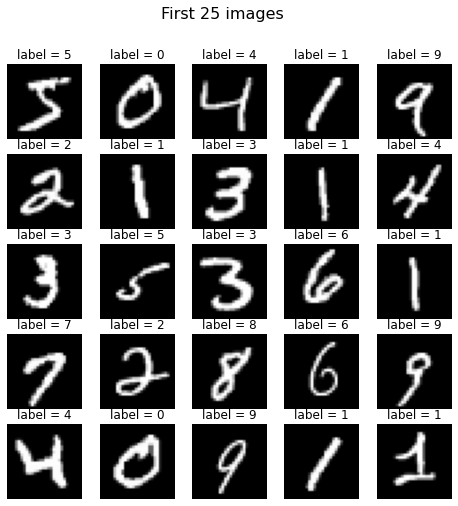

In [29]:
# Your code
fig, axes = plt.subplots(5, 5, figsize=(8,8))
fig.suptitle('First 25 images', fontsize=16)
img_index=0

for i in range (5):
    for j in range (5):
        axes[i, j].imshow(train_data[img_index, :].reshape(28,28))
        axes[i, j].set_title(f'label = {train_labels[img_index]}')
        axes[i, j].axis('off')
        img_index+=1

plt.show()


**Q3.a.** Write a function `train_iter(model, loss, batch_data, batch_labels, lr)` that performs one iteration of gradient descent given `model` and `loss` (subclasses of `Module`) on a batch `(batch_data, batch_labels)` with a learning rate `lr`, and returns the training loss value.

*Help:*
1. Make the predictions (`model.forward`)
2. Compute the loss between the predictions and the labels (`loss.forward`)
3. Compute its gradient wrt the predictions and the labels (`loss.backward`)
4. Backpropagate the gradient into the model (`model.backward`)
5. Perform gradient descent (`model.gradientStep`)




In [30]:
# Your code
def train_iter(model, loss, batch_data, batch_labels, lr):
    """
    Perform one iteration of training of the model
    """
    y = model.forward(batch_data)
    train_loss = loss.forward(y,batch_labels)
    grad_loss = loss.backward(y,batch_labels)
    grad_model = model.backward(batch_data,grad_loss)
    model.gradientStep(lr)

    return train_loss


**Q3.b.** Test your function. Write a simple loop that trains for 1 epoch a `SimpleMLP` using `MSE` loss on `train_data` with a learning rate of `1e-3` and batches of size `16`. You will print the loss every 10 iterations. To avoid overfitting, the training data should be shuffled before entering any new epoch.

*Note:* An **iteration** consists in running one batch of samples through the model; an **epoch** consists in running multiple iterations so that to process all the samples once.

*Help:* `np.random.shuffle` shuffles the content of an array inplace

In [31]:
lr = 1e-3
batch_size = 16

# Your code
nb_epochs = 1
nb_batches = N_train//batch_size
index = np.arange(N_train)
model = SimpleMLP()
loss = MSE()

for epoch in range(nb_epochs):
    #shuffling data
    np.random.shuffle(index)
    train_data,train_labels = train_data[index],train_labels[index]
    #Splitting the data in batches. The remainder is appended to the end if not divisile
    if N_train % batch_size == 0:
        train_data_batches = np.split(train_data, nb_batches)
        train_labels_batches = np.split(train_labels, nb_batches)
    else:
        last_batch = N_train % batch_size
        train_data_batches = np.split(train_data[:-last_batch,:], nb_batches)
        train_labels_batches = np.split(train_labels[:-last_batch], nb_batches)
        train_data_batches.append(train_data[-last_batch:,:])
        train_labels_batches.append(train_data[-last_batch:])
    #training
    for i in range(nb_batches):
        batch_loss = train_iter(model, loss, train_data_batches[i], train_labels_batches[i], lr)
        if (1+i) % 10 == 0:
            print(batch_loss)


1.9419040657916036
1.58538903093032
1.8685679645895288
1.7103174927760216
1.4918663235363052
1.2859987527441663
1.34573962255635
1.4291762702504407
1.2511968584487771
1.1101129318071283
1.3241967048679841
1.0081032759563375
1.1393057779856495
1.0475853675507398
1.2027139356050687
1.1653846049196446
1.0200252453954868
0.9463889087594908
1.051232587723603
1.0343473392178053
1.0962504821195331
0.9633410783389683
0.9136924705450207
0.84090511205351
0.9657391145269362
1.03354187613557
0.953999457304759
0.8098833244573176
1.1066375393716177
1.0815628631980094
0.9148366663550006
1.0106534445467035
0.9129876535958974
0.8339718606910115
0.9614526267773651
1.066618336680406
0.7269823860894482
0.7042576534042364
0.8557061668025764
0.825328553514
0.8784581240926348
0.6651378906613616
0.8738468135554778
0.8205743203505254
0.615551971753465
0.7162450001869403
0.9141458570615467
0.8313603534087649
0.7740273503254123
0.8574852621528901
0.6952994498257309
0.8409814181127507
0.7343673380961401
0.8312527

Analysing this initial result, the model seems to be learning, given the loss went down from 2.09 to 0.99 after only one epoch.

**Q4.a.** Write a function `evaluate(model, loss, data, labels)` that returns a couple `(loss, accuracy)` corresponding to the loss and accuracy computed on some `data`.

*NB:* `for` loops are so slow, avoid them as much as possible!




In [32]:
# Your code
def evaluate(model, loss, data, labels):
    """
    Evaluates the model's performance with respect to a given loss.
    Returns loss_val, accuracy
    """
    y_prob = model.forward(data)
    loss_val = loss.forward(y_prob,labels)
    y_pred = np.argmax(y_prob, axis= 1)
    accuracy = np.sum(y_pred == labels)/data.shape[0]

    return loss_val, accuracy


**Q4.b.** Use your function to evaluate the model trained in **Q3.b.** on the validation data.


In [33]:
# Your code
evaluate(model, loss, val_data, val_labels)

(0.7638726609831142, 0.552)

The model present a loss similar to the one calculated on the test set, but a low accuracy, predicting only about half of the images correctly



**Q4.c.** Check visually the quality of the results by plotting 25 validation examples and their predictions.

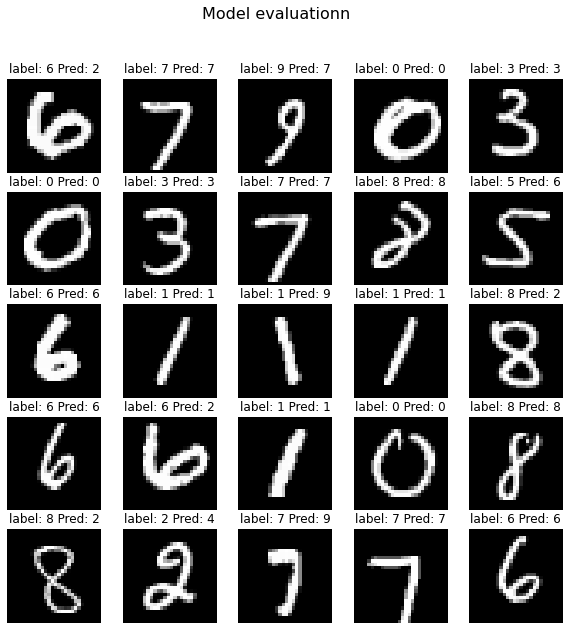

In [34]:
# Your code
y_prob = model.forward(val_data[:25,:])
y_pred = np.argmax(y_prob, axis= 1)

fig, axes = plt.subplots(5, 5, figsize=(10,10))
fig.suptitle('Model evaluationn', fontsize=16)
img_index=0
for i in range (5):
    for j in range (5):
        axes[i, j].imshow(val_data[img_index, :].reshape(28,28))
        axes[i, j].set_title(f'label: {val_labels[img_index]} Pred: {y_pred[img_index]}')
        axes[i, j].axis('off')
        img_index+=1

plt.show()

**Q4.d.** Make a failure case analysis on the full validation data using (i) a bar plot showing the percentage of error for each class and (ii) the prediction distribution over the classes for some failure cases. Comment briefly.

*Help:*
- `plt.bar` can be used to do a barplot
- `np.unique` is useful to compute unique elements in an array as well as respective count

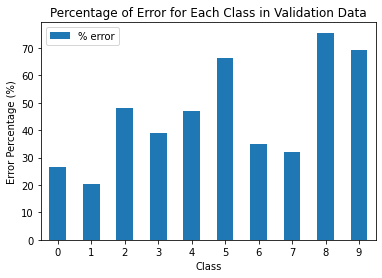

In [35]:
# Your code
import pandas as pd
#building the predictions dictionnary
y_prob = model.forward(val_data)
y_pred = np.argmax(y_prob, axis= 1)
predic_df = pd.DataFrame({'label':val_labels,'Prediction':y_pred})
predic_df['Wrond_pred'] = (predic_df['label'] != predic_df['Prediction'])
predic_df_agg = predic_df.groupby('label').agg({'label':'count','Wrond_pred':'sum'}).rename(columns={'label':'count_label','Wrond_pred':'nb_errors'})
predic_df_agg['% error'] = predic_df_agg['nb_errors']/predic_df_agg['count_label']*100
# Plotting the bar plot showing the percentage of error for each class
predic_df_agg.plot.bar(y='% error',rot=0)
plt.xlabel('Class')
plt.ylabel('Error Percentage (%)')
plt.title('Percentage of Error for Each Class in Validation Data')
plt.show()

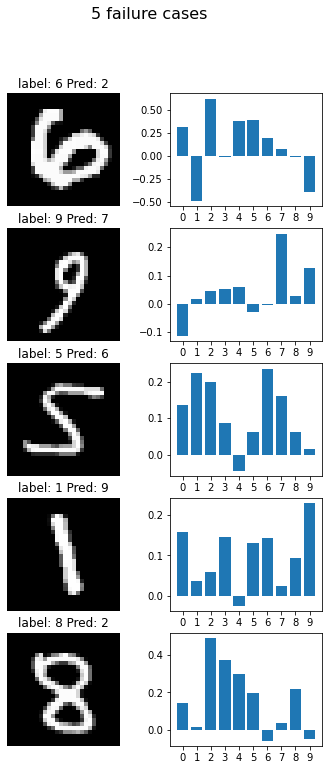

In [36]:
#picking 5 failure cases
nb_cases = 5
failure_index = predic_df[predic_df.Wrond_pred==True].index[:nb_cases]

fig, axes = plt.subplots(nb_cases, 2, figsize=(6,12))
fig.suptitle(f'{nb_cases} failure cases', fontsize=16)
x = np.arange(10)
for plt_index,i in enumerate(failure_index):
    #plotting the image
    axes[plt_index, 0].imshow(val_data[i, :].reshape(28,28))
    axes[plt_index, 0].set_title(f'label: {val_labels[i]} Pred: {y_pred[i]}')
    axes[plt_index, 0].axis('off')
    #plotting the distribution
    axes[plt_index, 1].bar(x,y_prob[i])
    axes[plt_index, 1].set_xticks(x)

plt.show()

By analysing the bar graph, we can see that the error is not evenly distributed between the classes. The models performs much better in the prediction of the class 1, while for classes 4, 5 and 8 it performs rather badly, being wrong over 60% of the time.

Through the failure cases, we can see that in some situations the true label had the second highest predicted score, indicating that with more training the model might have been able to predict these cases correctly.

## Part Ib. Training a neural network

**Q5.a.** Write a `train_epoch(model, loss, data, labels, val_data, val_labels, lr, batch_size)` function that trains a model for a whole epoch and returns train and val losses as well as accuracies on validation every 10 iterations (do not print anything during trainin this time). Test it to train a `SimpleMLP` from scratch for 2 epochs with the same parameters as in question **3.b.**

In [37]:
# Your code
def train_epoch(model, loss, data, labels, val_data, val_labels, lr, batch_size):
    """
    Trains a model for a whole epoch and returns train and val losses as well as accuracies on validation every 10 iterations
    """
    N_train = len(data)
    nb_batches = N_train//batch_size
    index = np.arange(N_train)
    np.random.shuffle(index)
    train_data,train_labels = data[index],labels[index]
    train_loss_list=[]
    val_loss_list=[]
    val_accuracy_list=[]
    train_loss=0

    #Splitting the data in batches. The remainder is appended to the end if not divisile
    if N_train % batch_size == 0:
        train_data_batches = np.split(train_data, nb_batches)
        train_labels_batches = np.split(train_labels, nb_batches)
    else:
        last_batch = N_train % batch_size
        train_data_batches = np.split(train_data[:-last_batch,:], nb_batches)
        train_labels_batches = np.split(train_labels[:-last_batch], nb_batches)
        train_data_batches.append(train_data[-last_batch:,:])
        train_labels_batches.append(train_data[-last_batch:])

    #training
    for i in range(nb_batches):
        train_loss += train_iter(model, loss, train_data_batches[i], train_labels_batches[i], lr)
        if (1+i) % 10 == 0:
            val_loss, val_accuracy = evaluate(model, loss, val_data, val_labels)
            train_loss_list.append(train_loss/(i+1)) #train loss is averaged between the batches
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)

    return train_loss_list, val_loss_list, val_accuracy_list

In [38]:
#testing the function
lr = 1e-3
batch_size = 16
model = SimpleMLP()
loss = MSE()
nb_epochs = 2
total_train_loss = []
total_val_loss = []
total_val_accuracy = []

for epoch in range(nb_epochs):
    train_losses, val_losses, val_accuracy = train_epoch(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size)
    total_train_loss.extend(train_losses)
    total_val_loss.extend(val_losses)
    total_val_accuracy.extend(val_accuracy)

In [73]:
print("train loss variation:",total_train_loss[0],total_train_loss[-1])
print("val loss variation:",total_val_loss[0],total_val_loss[-1])
print("accuracy variation:",total_val_accuracy[0],total_val_accuracy[-1])

train loss variation: 2.536442493194743 0.6864224320436076
val loss variation: 2.0900469988092487 0.6424619068646403
accuracy variation: 0.077 0.656


This simple test indicates that the model is learning, which means the function works as intended 

**Q5.b.** Plot train+val losses as well as the accuracy on the validation as a function of the number of iterations. Choose nice colors and add legends to ease the reading.

*Help:* you can simply use `plt.plot`

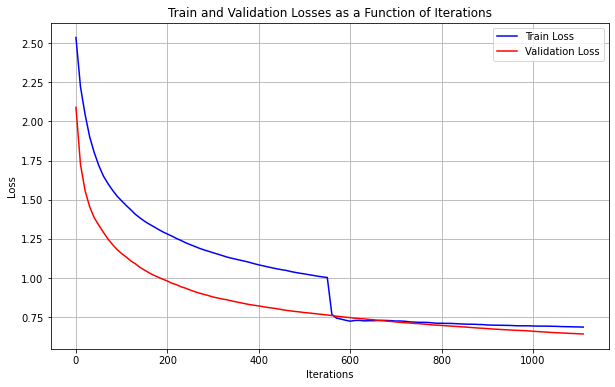

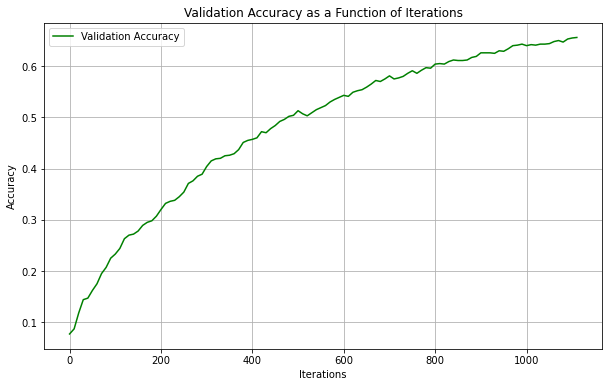

In [39]:
iterations = np.arange(len(total_train_loss))*10

# Plotting the train and validation losses
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_train_loss, label='Train Loss', color='blue')
plt.plot(iterations, total_val_loss, label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train and Validation Losses as a Function of Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_val_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy as a Function of Iterations')
plt.grid(True)
plt.legend()
plt.show()

We can see the model is learning well by the steady decrease of the loss on both the test and val set. The jump in the training loss is due to the start of a new cumulative average in the 2nd epoch. The accuracy in the val set algo goes higher through the iterations.

**Q6.a.** Based on the previous questions, design a function

<center><pre>train(model, loss, train_data, train_labels, val_data, val_labels, ...)</pre></center>

that performs a full training of the input `model` on the training data. Choose the arguments of your function (for instance, `batch_size`, `lr`, `epochs`, etc) according to what seems relevant to you. This function should plot at the end the evolution of train / val losses and accuracies.

In [40]:
# Your code
def train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs,plot=True):
    total_train_loss = []
    total_val_loss = []
    total_val_accuracy = []

    #training
    for epoch in range(nb_epochs):
        train_losses, val_losses, val_accuracy = train_epoch(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size)
        total_train_loss.extend(train_losses)
        total_val_loss.extend(val_losses)
        total_val_accuracy.extend(val_accuracy)

    if plot:
        iterations = np.arange(len(total_train_loss))*10
        # Plotting the train and validation losses
        plt.figure(figsize=(10, 6))
        plt.plot(iterations, total_train_loss, label='Train Loss', color='blue')
        plt.plot(iterations, total_val_loss, label='Validation Loss', color='red')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Train and Validation Losses as a Function of Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the validation accuracy
        plt.figure(figsize=(10, 6))
        plt.plot(iterations, total_val_accuracy, label='Validation Accuracy', color='green')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy as a Function of Iterations')
        plt.grid(True)
        plt.legend()
        plt.show()


**Q6.b.** Use your function to train a model with a good accuracy (decide for a epoch, learning rate, batch size...)

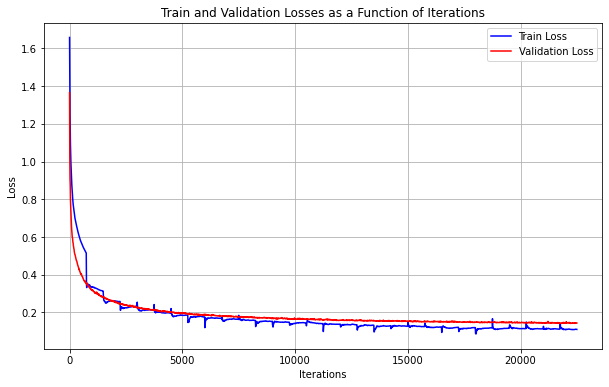

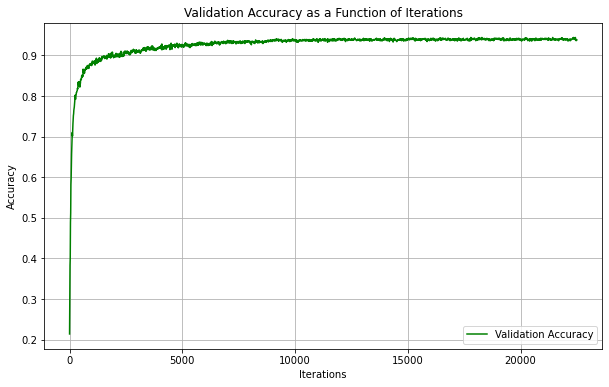

In [41]:
# Your code
lr = 1e-2
batch_size = 12
nb_epochs = 30
model = SimpleMLP()
loss = MSE()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)


## Part II. Overfitting

**Q7.** What's the number of parameters in the network `SimpleMLP` used in the first section?

**Your answer:** For each fc layer we have #features = (d_input+1)×d_output. This results in: ((784+1)×64) + ((64+1)×10) = 50890


**Q8.a.** Rewrite the definition of `SimpleMLP` to allow changing the dimension of the hidden layer. Test it by training 1 epoch with 128 hidden features and plotting its performances.

In [42]:
# New class definition
class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784,hidden_dimension=64, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_dimension)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_dimension, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

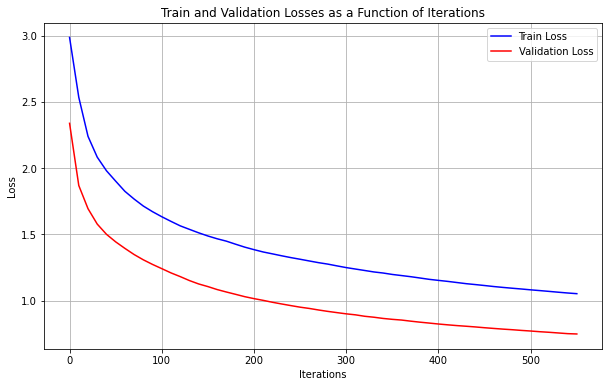

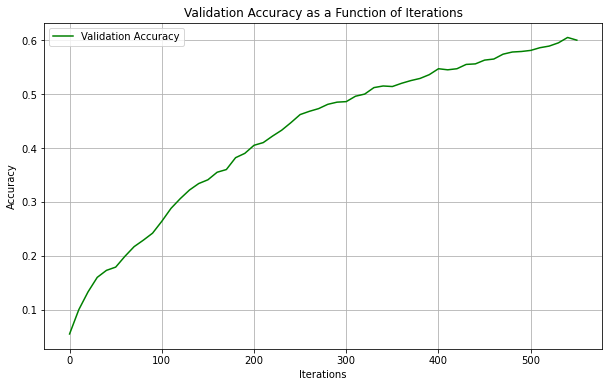

In [43]:
lr = 1e-3
batch_size = 16
nb_epochs = 1
model = SimpleMLP(hidden_dimension=128)
loss = MSE()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

**Q8.b.** Define a class `DoubleMLP` with three `Linear` layers and parameters to change their dimensions. Test it by training 1 epoch with [64, 32] hidden features and plotting its performances. Does it look better than `SimpleMLP`so far?

In [44]:
# Your code
class DoubleMLP(Module):
    """
    This class is a simple example of a neural network, composed of three
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784,hidden_dimension_1=64,hidden_dimension_2=32, num_classes=10):
        super(DoubleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_dimension_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_dimension_1, hidden_dimension_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(hidden_dimension_2, num_classes)
        
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

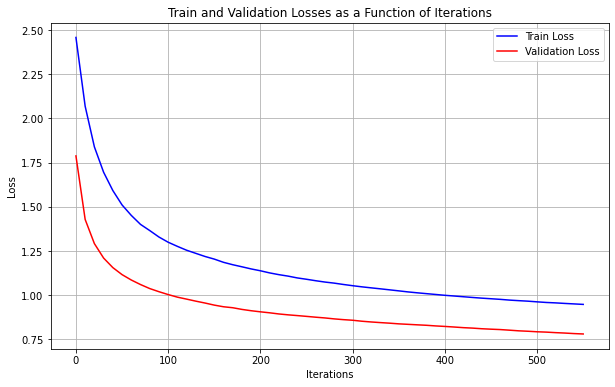

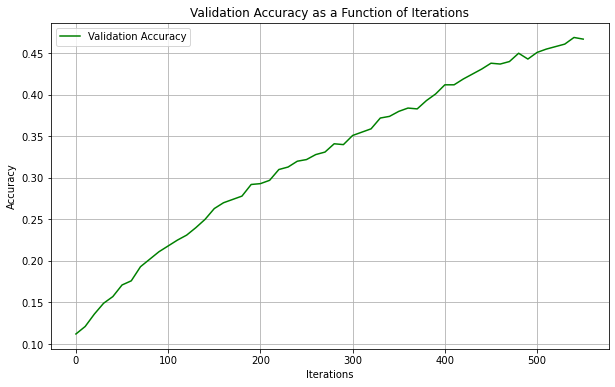

In [45]:
lr = 1e-3
batch_size = 16
nb_epochs = 1
model = DoubleMLP()
loss = MSE()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

By running just one epoch, the SimpleMLP obtained a better accuracy than the DoubleMLP, even if it's not as deep.

**Q8.c.** Define a class `DeepMLP` with a **list** parameter `hidden_features` that allows to vary the number of intermediate linear layers, and their dimensions:

- `DeepMLP([64])` should be equivalent to `SimpleMLP()`;
- `DeepMLP([64, 64, 64])` should be a MLP with four linear layers...

Test it by training 1 epoch with [64, 64, 32] hidden features and plotting its performances.

In [46]:
# Your code
class DeepMLP(Module):
    """
    This class is a generalized neural network, composed any number of
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784,hidden_features=[64], num_classes=10):
        super(DeepMLP, self).__init__()
        self.layers = []
        self.layers.append(Linear(in_dimension,hidden_features[0]))
        for i in range(len(hidden_features)):
            self.layers.append(ReLU())
            if i+1==len(hidden_features):
                self.layers.append(Linear(hidden_features[-1],num_classes))
            else:
                self.layers.append(Linear(hidden_features[i],hidden_features[i+1]))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, x, gradient):
        backward_layers = self.layers[::-1]
        for i,layer in enumerate(backward_layers):
            if i+1 == len(self.layers):
                gradient = layer.backward(x,gradient)
            else:
                gradient = layer.backward(backward_layers[(i+1)].output,gradient)
        return gradient

    def gradientStep(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.gradientStep(lr)

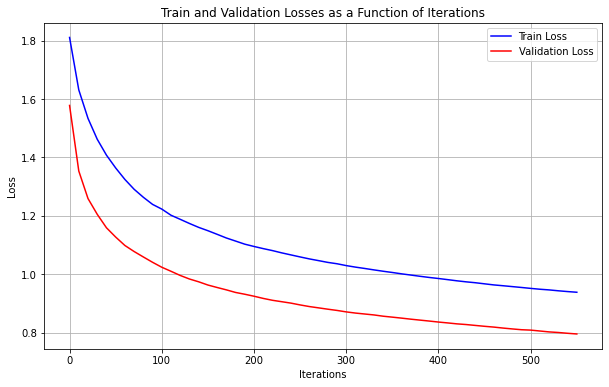

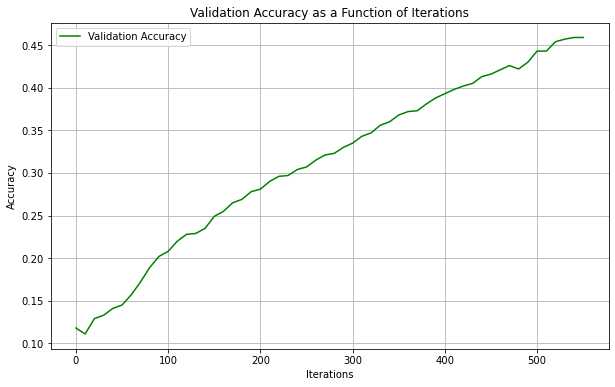

In [47]:
# Your code
lr = 1e-3
batch_size = 16
nb_epochs = 1
model = DeepMLP(hidden_features=[64,64,32])
loss = MSE()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

**Q9.** Benchmark / analyse some of the components introduced e.g. model structure (depth ie number of layers or width ie number of hidden features), batch size, learning rate, etc. by running full training and evaluating on the validation split.

Once you are happy with your final model, print the score obtained on the test data.

In [48]:
# Define ranges for different components to benchmark
model_structure =  [[64],[128],[256],[512],[64,64],[128,128],[256,256],[512,512],[64,64,64],[128,128,128],[256,256,256],[512,512,512]]  
batch_sizes = [10,20,40,60,90,120] 
learning_rates = [0.0001,0.0005,0.001,0.005, 0.01] 
#standard values for other trainings
nb_epochs = 10
lr = 1e-2
batch_size = 30
model = DeepMLP(hidden_features=[128,128])
loss = MSE()
plot = False
# Initialize lists to store results for analysis
results_struc = []
results_width = []
results_batch = []
results_lr = []

# Benchmarking different depths (number of layers)
for struc in model_structure:
    model = DeepMLP(hidden_features=struc)
    train(model, loss, train_data, train_labels, val_data, val_labels,
                                     batch_size, lr, nb_epochs,plot)
    results_struc.append((evaluate(model,loss,val_data,val_labels))[1])
dict_struc = pd.DataFrame({'struc':model_structure,'result':results_struc})

# Benchmarking different batch sizes
for batch_size_test in batch_sizes:
    model = DeepMLP(hidden_features=[64])
    
    train(model, loss, train_data, train_labels, val_data, val_labels,
                                     batch_size_test, lr, nb_epochs,plot)
    results_batch.append((evaluate(model,loss,val_data,val_labels))[1])
dict_batch = pd.DataFrame({'size':batch_sizes,'result':results_batch})

# Benchmarking different learning rates
for lr_test in learning_rates:
    model = DeepMLP(hidden_features=[64])
    
    train(model, loss, train_data, train_labels, val_data, val_labels,
                                     batch_size, lr_test, nb_epochs,plot)
    results_lr.append((evaluate(model,loss,val_data,val_labels))[1])
dict_lr = pd.DataFrame({'lr':learning_rates,'result':results_lr})

In [49]:
#retrieving optimal structure
opt_struc = dict_struc.iloc[dict_struc['result'].argmax()].values[0]
print(opt_struc)

[512, 512, 512]


In [50]:
#retrieving optimal batch size
opt_batch_size = dict_batch.iloc[dict_batch['result'].argmax()].values[0]
print(opt_batch_size)

10.0


In [51]:
#retrieving optimal learning rate
opt_lr = dict_lr.iloc[dict_lr['result'].argmax()].values[0]
print(opt_lr)

0.01


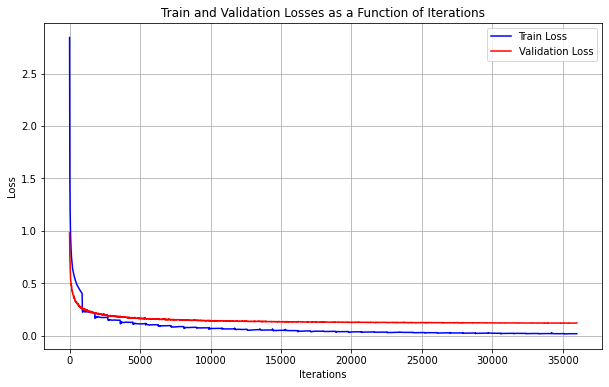

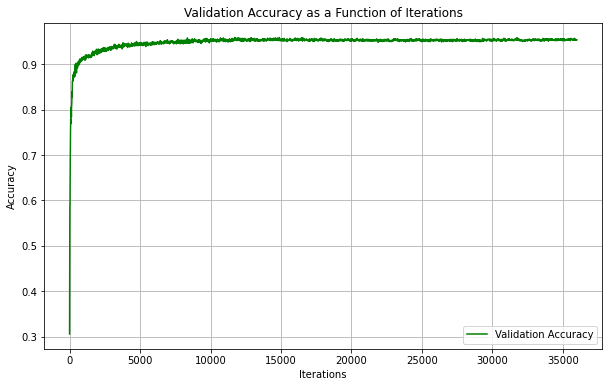

In [52]:
# optimal parameters
lr = opt_lr
batch_size = int(opt_batch_size)
nb_epochs = 40
model = DeepMLP(hidden_features=opt_struc)
loss = MSE()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

In [53]:
evaluate(model,loss,test_data,test_labels)

(0.14846755131431985, 0.9525)

## Part III. Going further

The following questions do not have a specific order, a limited number of bonus points can be granted on completing them.

**Q10.** Implement and test different non-linearities (Sigmoid, LeakyReLU, Tanh)

Modifyining DeepMLP class to make it work with any kind of activation

In [54]:
class DeepMLP(Module):
    """
    This class is a simple example of a neural network, composed of multiple
    linear layers, with a activation non-linearity in the middle
    """
    def __init__(self, in_dimension=784,hidden_features=[64], num_classes=10,activation=ReLU):
        super(DeepMLP, self).__init__()
        self.layers = []
        self.layers.append(Linear(in_dimension,hidden_features[0]))
        for i in range(len(hidden_features)):
            self.layers.append(activation())
            if i+1==len(hidden_features):
                self.layers.append(Linear(hidden_features[-1],num_classes))
            else:
                self.layers.append(Linear(hidden_features[i],hidden_features[i+1]))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, x, gradient):
        backward_layers = self.layers[::-1]
        for i,layer in enumerate(backward_layers):
            if i+1 == len(self.layers):
                gradient = layer.backward(x,gradient)
            else:
                gradient = layer.backward(backward_layers[(i+1)].output,gradient)
        return gradient

    def gradientStep(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.gradientStep(lr)

New activation functions

In [55]:

class Sigmoid(Module):
    def __init__(self, bias=True):
        super(Sigmoid, self).__init__()

    def forward(self, x):
        self.output = 1/(1+np.exp(-x))
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = self.output*(1-self.output)*gradOutput
        return self.gradInput
    
class Tanh(Module):
    def __init__(self, bias=True):
        super(Tanh, self).__init__()

    def forward(self, x):
        self.output = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return self.output

    def backward(self,x, gradOutput):
        self.gradInput = (1-self.output**2)*gradOutput
        return self.gradInput
    
class LeakyReLU(Module):
    def __init__(self, bias=True):
        super(LeakyReLU, self).__init__()

    def forward(self, x):
        self.output = np.where(x > 0, x, x * 0.01)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.where(x > 0, 1, 0.01)*gradOutput
        return self.gradInput

Testing the new functions

In [56]:
#standard accros the tests
lr = 1e-3
batch_size = 16
nb_epochs = 10
loss = MSE()

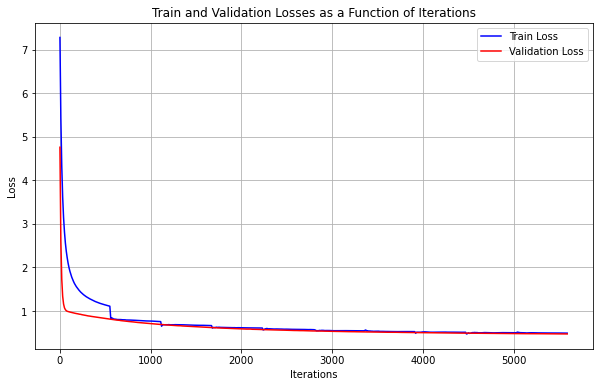

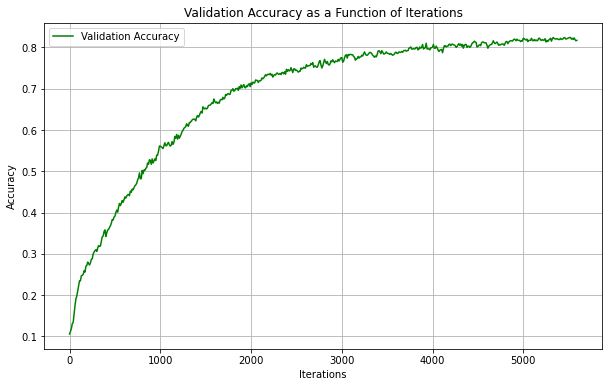

In [57]:
# Sigmoid
model = DeepMLP(activation=Sigmoid)
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

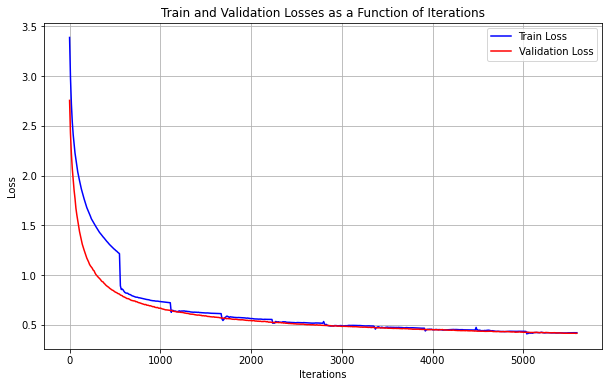

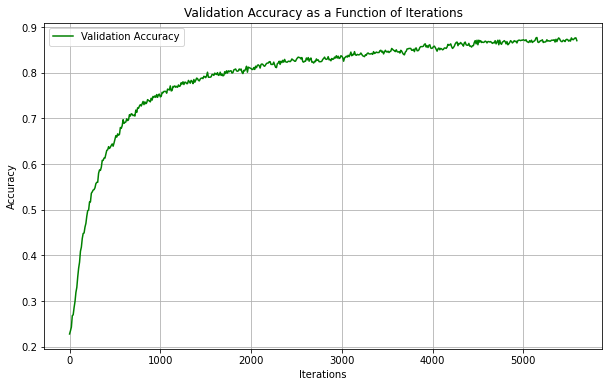

In [58]:
#Tanh
model = DeepMLP(activation=Tanh)
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

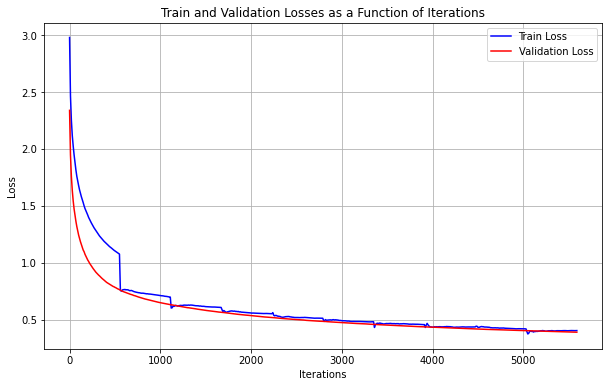

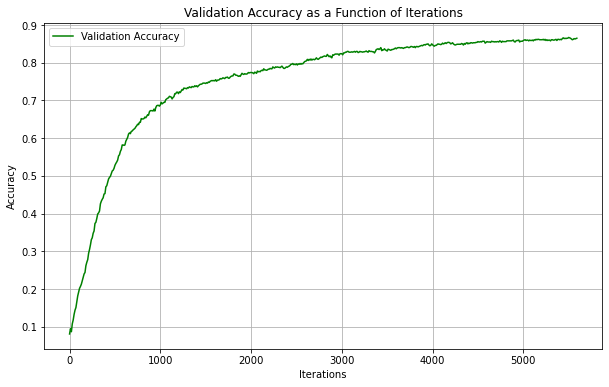

In [59]:
#LeakyReLU
model = DeepMLP(activation=LeakyReLU)
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

Both the LeakyReLU and the Tanh seemed to have perfomed better than the Sigmoid, with a better accuracy and faster learning.

**Q11.** Implement and test different loss functions (L1, Cross-Entropy)

Defining the new losses

In [60]:
class L1(Module):
    """
    This implementation of the L1 loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (batch_size)
    """
    def __init__(self, num_classes=10):
        super(L1, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1
        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        self.output = np.sum(np.abs(target-x), axis=1)
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = np.where((target-x) > 0, -1, 1)/ x.shape[0]
        return self.gradInput
    
class CrossEntropy(Module):
    """
    This implementation of the CrossEntropy loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (batch_size)
    """
    def __init__(self, num_classes=10):
        super(CrossEntropy, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1
        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        #softmax
        max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x-max_x)
        sum_x = np.sum(exp_x, axis=1, keepdims=True)
        self.softmax_x = exp_x / sum_x
        #-log likelihood
        self.output = -np.sum(target*np.log(self.softmax_x),axis=1)
        return np.mean(self.output)
    
    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = (self.softmax_x - target)/ x.shape[0]
        return self.gradInput

Testing the losses

In [61]:
#standard accros the tests
lr = 1e-3
batch_size = 20
nb_epochs = 5

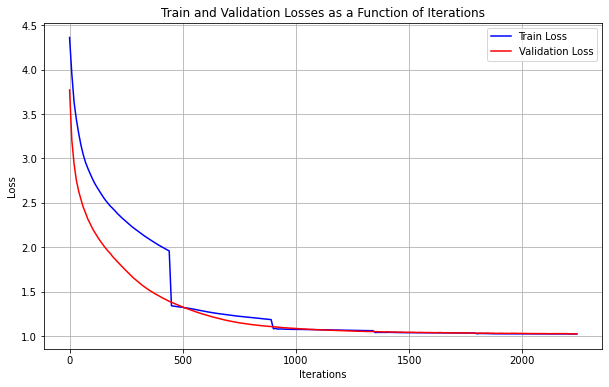

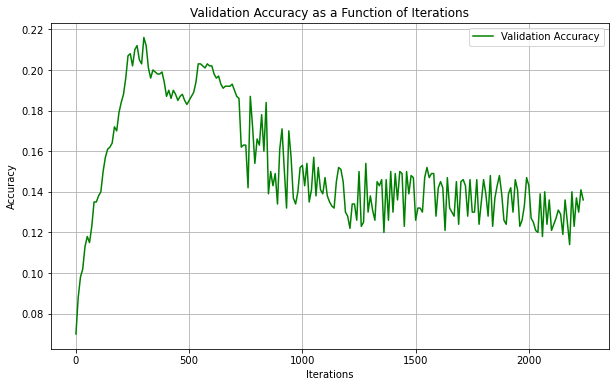

In [62]:
loss = L1()
model = DeepMLP()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

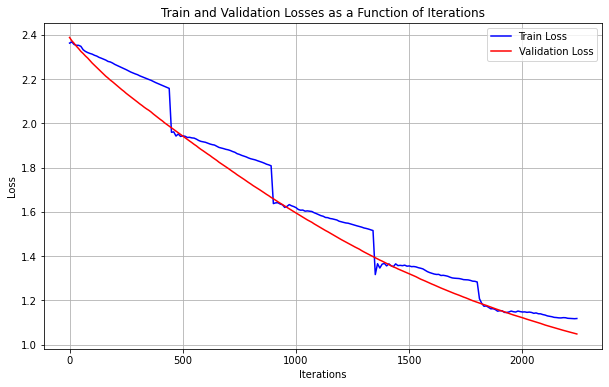

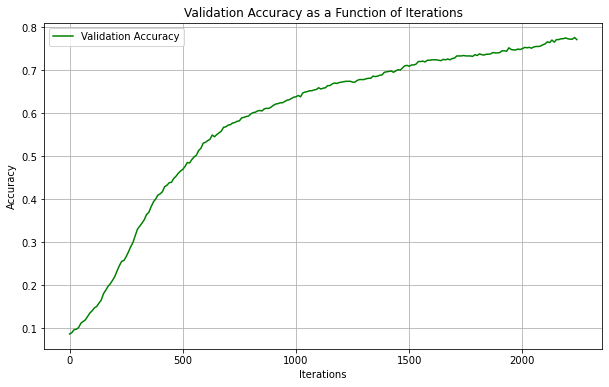

In [63]:
#CrossEntropy loss
loss = CrossEntropy()
model = DeepMLP()
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

The L1 loss does not seem to useful in our problem, with its value converging to a local minimum far from the optimal. The cross-entropy presents a good behavior and makes the model learn through the training.

**Q12.** Add some momentum to your training procedure. How does it change the training behavior?

In [64]:
#Updating the gradientStep method
class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features,momentum=0, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.momentum = momentum
        self.delta_w = 0
        self.delta_b = 0

        std = math.sqrt(2/in_features) # He init because we have ReLU.
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr):
        self.delta_w = self.momentum*self.delta_w + self.gradWeight
        self.delta_b = self.momentum*self.delta_b + self.gradBias
        self.weight = self.weight - lr*self.delta_w
        self.bias = self.bias - lr*self.delta_b

In [74]:
#Redefining the architecture to include momentum
class DeepMLP(Module):
    """
    This class is a simple example of a neural network, composed of multiple
    linear layers, with a activation non-linearity in the middle
    """
    def __init__(self, momentum=0,in_dimension=784,hidden_features=[64], num_classes=10,activation=ReLU):
        super(DeepMLP, self).__init__()
        self.layers = []
        self.layers.append(Linear(in_dimension,hidden_features[0],momentum))
        for i in range(len(hidden_features)):
            self.layers.append(activation())
            if i+1==len(hidden_features):
                self.layers.append(Linear(hidden_features[-1],num_classes,momentum))
            else:
                self.layers.append(Linear(hidden_features[i],hidden_features[i+1],momentum))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, x, gradient):
        backward_layers = self.layers[::-1]
        for i,layer in enumerate(backward_layers):
            if i+1 == len(self.layers):
                gradient = layer.backward(x,gradient)
            else:
                gradient = layer.backward(backward_layers[(i+1)].output,gradient)
        return gradient

    def gradientStep(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.gradientStep(lr)

In [66]:
#standard accros the tests
lr = 1e-4
batch_size = 15
nb_epochs = 10

Baseline result without momentum

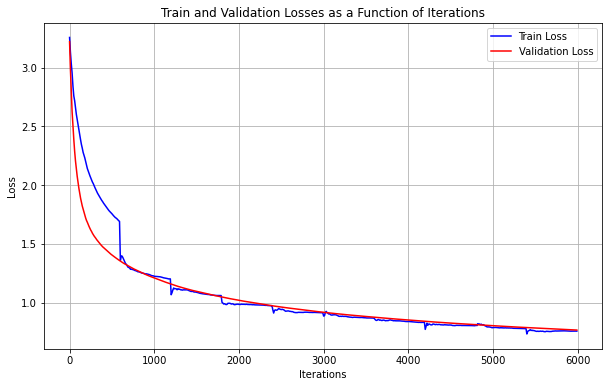

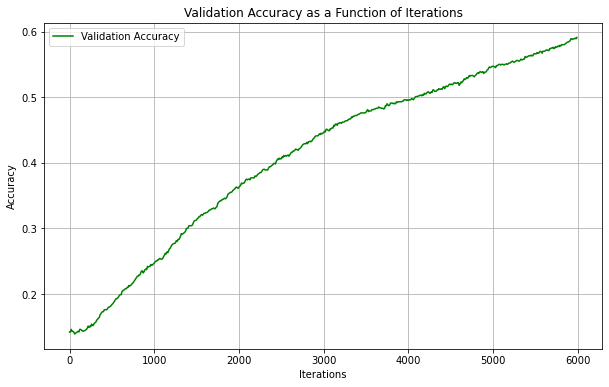

In [67]:
loss = MSE()
model = DeepMLP(momentum=0)
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

Now with momentum

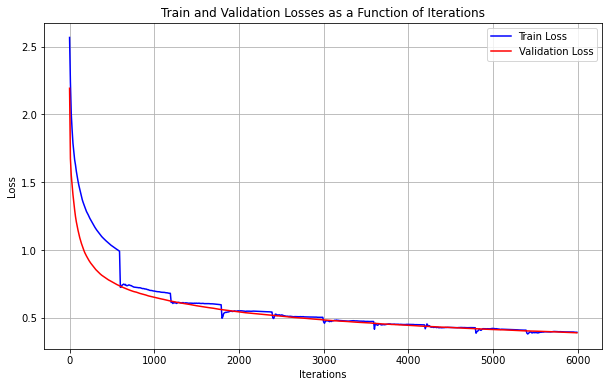

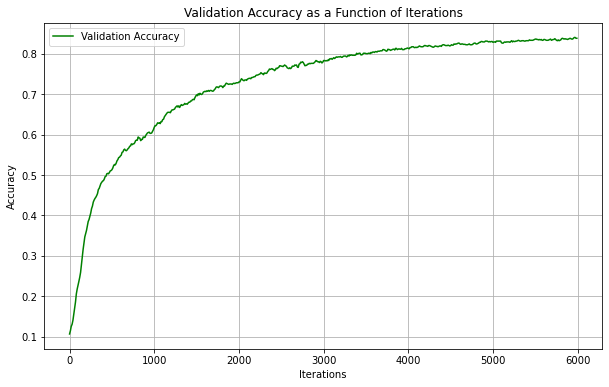

In [68]:
loss =MSE()
model = DeepMLP(momentum=0.9)
train(model, loss, train_data, train_labels, val_data, val_labels, batch_size, lr, nb_epochs)

Analysing the graphs, we can see the model with momentum reached a higher accuracy with much less iterations, as was expected theoretically.